__purpose__
- Call SNPs using FreeBayes as implemented in dDocent
- Create a pseudogenome - using the major allele calculated independently for each species, create a species-specific ref.fa where the major allele for a species replaces the reference allele in the fasta file.
- Aferwards, recall SNPs on the pseudogenome independently for each specieskx b w

In [2]:
from pythonimports import *

In [3]:
DIR = '/home/lindb/eckertlab/BURT/002_trim_and_map/loblolly_mapping/BURT/03_dedup_rg_filtered_indexed_sorted_bamfiles'

# get some of the files that dDocent uses, that I'll use in customized freebayes calls

#### loblolly bamfiles

```bash
# cd dedup directory with bamfiles that are ready
LOBDIR=/home/lindb/eckertlab/BURT/002_trim_and_map/loblolly_mapping/BURT
cd $LOBDIR/03_dedup_rg_filtered_indexed_sorted_bamfiles

# get a list of bamfiles to pass to samtools merge
ls *rd.bam > bamlist.list

# merge 
samtools merge -@ 64 -b bamlist.list -f cat-RRG.bam
samtools index cat-RRG.bam
wait
bedtools merge -i cat-RRG.bam -bed >  mapped.bed

# get list of samps (cmds from dDocent, I hate bash)
ls *rd.bam > namelist
sed -i'' -e 's/_rd.bam//g' namelist

# get covstats so I can create a "mapped.*.bed" file for each samp below
export FB2=64
export REF=/home/lindb/eckertlab/BURT/refs/lobololly_stitched_ref/Pita2_stitched_2/pita2_stitch_v2.fa
mawk -v OFS='\t' {'print $1,$2'} $REF > genome.file
cat namelist | parallel --eta -j $FB2 "bedtools coverage -b {}_rd.bam -a mapped.bed -counts -sorted -g genome.file > {}.cov.stats"
sort=sort
```

#### this next dDocent command would have taken way too long, I can just do it in python

this command = 

```bash
cat *.cov.stats | $sort -k1,1 -k2,2n | bedtools merge -i - -c 4 -o sum > cov.stats
```

this command just sums the final column in these .cov.stats files and merges into one file

In [1]:
from pythonimports import *

# get engines
lview,dview = get_client('xmn')

100 100


In [2]:
def get_col(f):
    """Get column 3 that has the counts."""
    import pandas
    if f.endswith('.txt') or f.endswith('.stats'):
        df = pandas.read_table(f, header=None, usecols=[3])[3]
    else:
        df = pklload(f)
    return df
dview['get_col'] = get_col

def get_cols(files, num, numsnps):
    """Call get_col() for each file in files."""
    import pandas, pickle, os
    from tqdm.notebook import tqdm
    
    num = str(num).zfill(3)
    tmpdir = '/home/lindb/eckertlab/BURT/002_trim_and_map/loblolly_mapping/BURT/03_dedup_rg_filtered_indexed_sorted_bamfiles/tmpdir'

    blank = pandas.Series([0 for y in range(numsnps)])
    for f in tqdm(files):
        blank += get_col(f)

    file = os.path.join(tmpdir, f'{num}.pkl')
    pkldump(blank, file)
    return file

dview['nrow'] = nrow
dview['pkldump'] = pkldump
dview['pklload'] = pklload

In [3]:
DIR = '/home/lindb/eckertlab/BURT/002_trim_and_map/loblolly_mapping/BURT/03_dedup_rg_filtered_indexed_sorted_bamfiles'
files = fs(DIR, endswith='.cov.stats')
len(files)

1135

In [4]:
numsnps = nrow(get_col(files[0]))
numsnps

12256810

In [28]:
# test function
file = get_cols(files[:3], 0, numsnps)

In [29]:
# look at output
pklload(file)

0           0
1           0
2           0
3           0
4           0
           ..
12256805    0
12256806    0
12256807    0
12256808    0
12256809    0
Length: 12256810, dtype: int64

In [30]:
# sum output
sum(pklload(file))

713894

In [5]:
def gather(files, lview, numsnps=numsnps, thresh=10):
    """Call get_cols() in parallel for batches of files."""
    from tqdm.notebook import tqdm
    
    jobs = []
    to_send = []
    for i,f in enumerate(tqdm(files)):
        to_send.append(f)
        if len(to_send) == thresh or (i+1) == len(files):
            jobs.append(lview.apply_async(get_cols, *(to_send, len(jobs), numsnps)))
            if (i+1) != len(files):
                to_send = []
    return jobs

In [6]:
jobs = gather(files, lview, thresh=10)
watch_async(jobs)



Watching 114 jobs ...


100%|██████████| 114/114 [04:42<00:00,  2.48s/it] 


In [7]:
pkls = [j.r for j in jobs]
len(pkls)

114

In [8]:
# after moving all pkl files into tmptmp in command line
tmppkls = fs(op.join(op.join(DIR, 'tmpdir'), 'tmptmp'))
len(tmppkls)

114

In [9]:
tmpjobs = gather(tmppkls, lview)
watch_async(tmpjobs)



Watching 12 jobs ...


100%|██████████| 12/12 [00:12<00:00,  1.07s/it]


In [10]:
# after deleteing the old tmptmp files and moving tmpdir files into tmpmtp in command line
tmppkls = fs(op.join(op.join(DIR, 'tmpdir'), 'tmptmp'))
outfile = get_cols(tmppkls, 0, numsnps)
outfile

'/home/lindb/eckertlab/BURT/002_trim_and_map/loblolly_mapping/BURT/03_dedup_rg_filtered_indexed_sorted_bamfiles/tmpdir/000.pkl'

In [11]:
# num loci * num samples with data for each locus
cov_stats = pklload(outfile)
sum(cov_stats)

421524004

In [20]:
sum(cov_stats>200)

687337

In [22]:
max(cov_stats)

1389573

In [24]:
sum((cov_stats>120) & (cov_stats<100000))

1098731

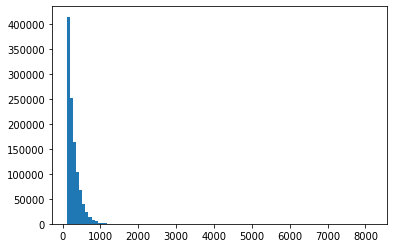

In [23]:
plt.hist(cov_stats[(cov_stats>120) & (cov_stats<100000)], bins=100)
plt.show()

In [28]:
# get a cov.stats dataframe, and replace column 3
blank = pd.read_table(op.join(DIR, 'P-AL-4-10.cov.stats'), header=None)
blank[3] = cov_stats
blank.head()

,0,1,2,3
0,Scaffold_1,801,985,12
1,Scaffold_1,2108,2202,1
2,Scaffold_1,6093,6216,15
3,Scaffold_1,9666,9712,1
4,Scaffold_1,9974,10019,2


In [29]:
# write file to the output file from the original dDocent command above
blank.to_csv(op.join(DIR, 'cov.stats'), sep='\t', index=False, header=False)

```bash
# continue with dDocent code
NUMProc=64
DP=$(mawk '{print $4}' cov.stats | $sort -rn | perl -e '$d=.00005;@l=<>;print $l[int($d*@l)]')  # = 1128
CC=$( mawk -v x=$DP '$4 < x' cov.stats | mawk '{len=$3-$2;lc=len*$4;tl=tl+lc} END {OFMT = "%.0f";print tl/"'$NUMProc'"}')  # = 1113999950

mawk -v x=$DP '$4 < x' cov.stats |$sort -V -k1,1 -k2,2 | mawk -v cutoff=$CC 'BEGIN{i=1}
        {
        len=$3-$2;lc=len*$4;cov = cov + lc
        if ( cov < cutoff) {x="mapped."i".bed";print $1"\t"$2"\t"$3 > x}
        else {i=i+1; x="mapped."i".bed"; print $1"\t"$2"\t"$3 > x; cov=0}
        }'

# set up poplist for FreeBayes - here each stand is treated as a pop (may change second round SNP calling)
cut -f1 -d "_" namelist > p
paste namelist p > popmap
rm p


# MOVE TO TMUX g'night!

#-------------------------------------------------------------------
call_genos(){
        samtools view -@$FB2 -b -1 -L mapped.$1.bed -o split.$1.bam ../03_dedup_rg_filtered_indexed_sorted_bamfiles/cat-RRG.bam
        samtools index split.$1.bam
        freebayes -b split.$1.bam -t mapped.$1.bed -v raw.$1.vcf -f $REF -m 5 -q 5 -E 3 --min-repeat-entropy 1 -V --populations popmap -n 10 2> fb.$1.error.log
        if [ $? -eq 0 ]; then
                echo "freebayes instance $1 completed successfully." >> freebayes.log
                rm split.$1.bam*
                rm fb.$1.error.log
        else
                echo -e "\n\nERROR: freebayes instance DID NOT COMPLETE\n\nSee below:"
                cat fb.$1.error.log
                echo -e "$?" "\t" "$1" >> freebayes.error
                exit 1
        fi

}
export -f call_genos
#-------------------------------------------------------------------

# reexport in tmux env
export REF=/home/lindb/eckertlab/BURT/refs/lobololly_stitched_ref/Pita2_stitched_2/pita2_stitch_v2.fa
export NUMProc=64
export FB2=$(( $NUMProc / 8 ))

ls mapped.*.bed | sed 's/mapped.//g' | sed 's/.bed//g' | shuf | parallel --bar --halt now,fail=5 --env call_genos --memfree 450 -j $NUMProc --no-notice "call_genos {} 2> /dev/null"
```

```bash
# exit tmux session and continue with dDocent commands

# rm individual bed files, add leading zero to raw.vcfs
rm mapped.*.bed
mv raw.1.vcf raw.01.vcf 2>/dev/null
mv raw.2.vcf raw.02.vcf 2>/dev/null
mv raw.3.vcf raw.03.vcf 2>/dev/null
mv raw.4.vcf raw.04.vcf 2>/dev/null
mv raw.5.vcf raw.05.vcf 2>/dev/null
mv raw.6.vcf raw.06.vcf 2>/dev/null
mv raw.7.vcf raw.07.vcf 2>/dev/null
mv raw.8.vcf raw.08.vcf 2>/dev/null
mv raw.9.vcf raw.09.vcf 2>/dev/null

# combine vcfs
vcfcombine raw.*.vcf | sed -e 's/       \.\:/   \.\/\.\:/g' > TotalRawSNPs.vcf

# move to new dir
mkdir ../04_vcfs
mv *vcf ../04_vcfs/

# gzip file, keep original
cd ../04_vcfs
gzip -c TotalRawSNPs.vcf > TotalRawSNPs.vcf.gz

```

In [ ]:
convert to txt file

In [1]:
gatk VariantsToTable --variant TotalRawSNPs.vcf \
-F CHROM \
-F REF \
-F ALT \
-F AF \
-F QUAL \
-F TYPE \
-F FILTER \
-F AC \
-F AN \
-F NUMALT \
-F DP \
-f ODDS \
-GF GT \
-GF GQ \
-GF GL \
-GF DP \
-GF AD \
-GF RO \
-GF AO \
-GF QR \
-GF QA \
-O TotalRawSNPs.txt

SyntaxError: invalid syntax (<ipython-input-1-15b14196a33d>, line 1)

In [ ]:
/data/programs/gatk-4.1.0.0/gatk VariantsToTable \
--variant TotalRawSNPs.vcf.gz \
-F CHROM -F REF -F ALT -F AF -F QUAL -F TYPE -F FILTER -F AC -F AN -F NUMALT -F DP -F ODDS \
-GF GT -GF GQ -GF GL -GF DP -GF AD -GF RO -GF AO -GF QR -GF QA \
-O TotalRawSNPs.txt --split-multi-allelic

In [3]:
# godel
!wget -qO- http://ipecho.net/plain | xargs echo

128.172.189.202


In [ ]:
# yeaman
print('136.159.160.144')